# Energy Forecasting — LSTM, RandomForest, ARIMA & Prophet

This notebook demonstrates a complete educational workflow for forecasting energy consumption using RandomForest, LSTM, ARIMA, and Prophet. It includes data loading, cleaning, EDA, model training, evaluation, visual comparisons, and student exercises.


## Instructions

Place `cleaned_energy.csv` in the same folder to use real data. Otherwise a synthetic sample will be created automatically. Cells that require optional libraries (Prophet/ARIMA) are wrapped with try/except and show messages if libraries are missing.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

print('Libraries imported')

Libraries imported


In [2]:
import os
DATA_PATH='cleaned_energy.csv'
SAMPLE_PATH='sample_household.csv'
if os.path.exists(DATA_PATH):
    df=pd.read_csv(DATA_PATH)
else:
    date_rng=pd.date_range(start='2020-01-01', end='2020-03-31 23:00:00', freq='H')
    np.random.seed(42)
    n=len(date_rng)
    base=100+20*np.sin(2*np.pi*date_rng.hour/24)+5*np.sin(2*np.pi*date_rng.dayofyear/365)
    noise=np.random.normal(0,3,size=n)
    consumption=base+noise
    df=pd.DataFrame({'date':date_rng,'consumption':consumption})
    df.to_csv(SAMPLE_PATH,index=False)
df.head()

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


In [3]:
df['DateTime']=pd.to_datetime(df['DateTime'],errors='coerce')
df=df.dropna(subset=['DateTime']).set_index('DateTime')
print('Data shape:',df.shape)
df.head()

Data shape: (52416, 8)


,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
DateTime,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


In [4]:
df.rename({'Zone 1 Power Consumption':'consumption'},axis='columns',inplace=True)
df.head()

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
DateTime,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


## EDA

In [5]:
df.describe().T
# print(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
Temperature,52416.0,18.810024,5.815476,3.247000,14.410000,18.780000,22.890000,40.01000
Humidity,52416.0,68.259518,15.551177,11.340000,58.310000,69.860000,81.400000,94.80000
Wind Speed,52416.0,1.959489,2.348862,0.050000,0.078000,0.086000,4.915000,6.48300
general diffuse flows,52416.0,182.696614,264.400960,0.004000,0.062000,5.035500,319.600000,1163.00000
diffuse flows,52416.0,75.028022,124.210949,0.011000,0.122000,4.456000,101.000000,936.00000
consumption,52416.0,32344.970564,7130.562564,13895.696200,26310.668692,32265.920340,37309.018185,52204.39512
Zone 2 Power Consumption,52416.0,21042.509082,5201.465892,8560.081466,16980.766032,20823.168405,24713.717520,37408.86076
Zone 3 Power Consumption,52416.0,17835.406218,6622.165099,5935.174070,13129.326630,16415.117470,21624.100420,47598.32636


In [6]:
fig=px.line(df,y='consumption',title='Consumption Time Series')
fig.show()

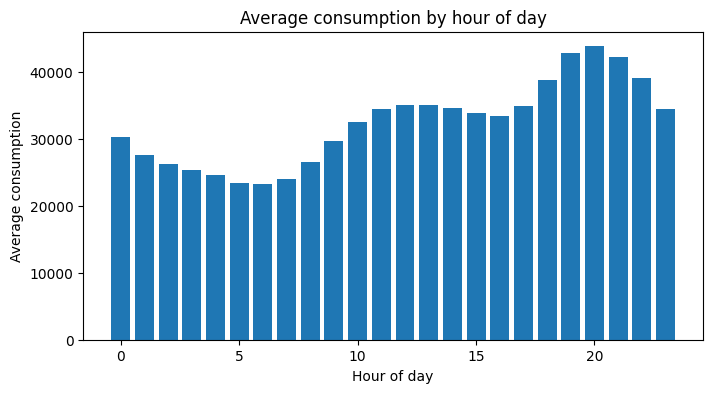

In [7]:
hourly=df['consumption'].groupby(df.index.hour).mean()
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.bar(hourly.index,hourly.values)
plt.xlabel('Hour of day')
plt.ylabel('Average consumption')
plt.title('Average consumption by hour of day')
plt.show()

## Feature engineering

In [8]:
series=df['consumption'].resample('H').mean().ffill()
feat=pd.DataFrame({'y':series})
feat['hour']=feat.index.hour
feat['weekday']=feat.index.weekday
feat['dayofyear']=feat.index.dayofyear
feat['lag_24']=feat['y'].shift(24)
feat['lag_1']=feat['y'].shift(1)
feat['rolling_24']=feat['y'].rolling(24,min_periods=1).mean()
feat=feat.dropna()
feat.head()

,y,hour,weekday,dayofyear,lag_24,lag_1,rolling_24
DateTime,,,,,,,
2017-01-02 00:00:00,25303.291138,0,0,2,29197.974683,30072.911392,28302.953586
2017-01-02 01:00:00,22512.405062,1,0,2,24657.215190,25303.291138,28213.586497
2017-01-02 02:00:00,20945.822783,2,0,2,22083.037973,22512.405062,28166.202531
2017-01-02 03:00:00,20097.215188,3,0,2,20811.139240,20945.822783,28136.455696
2017-01-02 04:00:00,20066.835442,4,0,2,20475.949367,20097.215188,28119.409282


## RandomForest baseline

In [9]:
X=feat[['hour','weekday','dayofyear','lag_24','lag_1','rolling_24']]
y=feat['y']
split=int(0.8*len(X))
X_train,X_test=X.iloc[:split],X.iloc[split:]
y_train,y_test=y.iloc[:split],y.iloc[split:]
rf=RandomForestRegressor(n_estimators=100,random_state=0)
rf.fit(X_train,y_train)
rf_pred=rf.predict(X_test)
print('RF RMSE:',mean_squared_error(y_test,rf_pred))
print('RF MAE:',mean_absolute_error(y_test,rf_pred))
fig=go.Figure()
fig.add_trace(go.Scatter(x=y_test.index,y=y_test.values,name='Actual'))
fig.add_trace(go.Scatter(x=y_test.index,y=rf_pred,name='RF Pred'))
fig.update_layout(title='RF: Actual vs Predicted')
fig.show()

RF RMSE: 1779445.8699918103
RF MAE: 1014.6150342310918


## LSTM model

In [10]:
from sklearn.preprocessing import MinMaxScaler
values=feat['y'].values.reshape(-1,1)
scaler=MinMaxScaler()
scaled=scaler.fit_transform(values)
seq_len=24
Xs,ys=[],[]
for i in range(seq_len,len(scaled)):
    Xs.append(scaled[i-seq_len:i,0])
    ys.append(scaled[i,0])
Xs,ys=np.array(Xs),np.array(ys)
Xs=Xs.reshape((Xs.shape[0],Xs.shape[1],1))
split_idx=int(0.8*len(Xs))
X_train_s,X_test_s=Xs[:split_idx],Xs[split_idx:]
y_train_s,y_test_s=ys[:split_idx],ys[split_idx:]

In [11]:
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM,Dense,Dropout
    model=Sequential([LSTM(64,input_shape=(X_train_s.shape[1],1)),Dense(32,activation='relu'),Dense(1)])
    model.compile(optimizer='adam',loss='mse')
    model.fit(X_train_s,y_train_s,epochs=20,batch_size=32,verbose=1)
    pred_s=model.predict(X_test_s).flatten()
    pred_inv=scaler.inverse_transform(pred_s.reshape(-1,1)).flatten()
    true_inv=scaler.inverse_transform(y_test_s.reshape(-1,1)).flatten()
    print('LSTM RMSE:',mean_squared_error(true_inv,pred_inv))
    print('LSTM MAE:',mean_absolute_error(true_inv,pred_inv))
    fig=go.Figure()
    fig.add_trace(go.Scatter(y=true_inv,name='Actual'))
    fig.add_trace(go.Scatter(y=pred_inv,name='LSTM Pred'))
    fig.update_layout(title='LSTM: Actual vs Predicted (sample)')
    fig.show()
except Exception as e:
    print('TensorFlow/Keras not available or failed to train LSTM:',e)
    print('Install TensorFlow with: pip install tensorflow')

Epoch 1/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0222
Epoch 2/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0053
Epoch 3/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0037
Epoch 4/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0033
Epoch 5/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0026
Epoch 6/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0023
Epoch 7/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0020
Epoch 8/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0018
Epoch 9/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0016
Epoch 10/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0015
Epoch 11/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0015
Epoch 12/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013
Epoch 13/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013
Epoch 14/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014
Epoch 15/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - lo

## ARIMA (pmdarima/statsmodels)

In [13]:
import pmdarima
import numpy
print("pmdarima version:", pmdarima.__version__)
print("numpy version:", numpy.__version__)

pmdarima version: 2.0.4
numpy version: 2.2.6


In [ ]:
# import pmdarima as pm
# # arima_model=pm.auto_arima(feat['y'], seasonal=True, m=12, error_action='ignore', suppress_warnings=True, n_jobs=-1)
# arima_model = pm.auto_arima(
#     feat['y'].iloc[-1000:].astype('float32'),
#     seasonal=True,
#     m=24,
#     start_p=0, start_q=0,
#     max_p=3, max_q=3,
#     start_P=0, start_Q=0,
#     max_P=2, max_Q=2,
#     d=None, D=None,
#     trace=True,              # See progress
#     error_action='ignore',
#     suppress_warnings=True,
#     stepwise=True            # MUCH faster search
# )
# print(arima_model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=20263.242, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=4.25 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=23439.565, Time=0.02 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=20227.917, Time=0.65 sec
 ARIMA(0,0,0)(2,0,0)[24] intercept   : AIC=20221.275, Time=31.20 sec
 ARIMA(0,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=7.94 sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=1.65 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=inf, Time=36.61 sec
 ARIMA(0,0,1)(2,0,0)[24] intercept   : AIC=19510.575, Time=9.62 sec
 ARIMA(0,0,1)(1,0,0)[24] intercept   : AIC=19548.047, Time=0.79 sec
 ARIMA(0,0,1)(2,0,1)[24] intercept   : AIC=inf, Time=10.71 sec
 ARIMA(0,0,1)(1,0,1)[24] intercept   : AIC=inf, Time=2.37 sec
 ARIMA(1,0,1)(2,0,0)[24] intercept   : AIC=17019.638, Time=10.64 sec
 ARIMA(1,0,1)(1,0,0)[24] intercept   : AIC=

In [ ]:
# n_periods=int(0.2*len(feat))
# arima_forecast=arima_model.predict(n_periods=n_periods)
# idx=feat.index[-n_periods:]
# fig=go.Figure()
# fig.add_trace(go.Scatter(x=feat.index,y=feat['y'],name='Actual'))
# fig.add_trace(go.Scatter(x=idx,y=arima_forecast,name='ARIMA Forecast'))
# fig.update_layout(title='ARIMA Forecast (auto_arima)')
# fig.show()

In [ ]:
# try:
#     import pmdarima as pm
#     arima_model=pm.auto_arima(feat['y'], seasonal=True, m=24, error_action='ignore', suppress_warnings=True)
#     print(arima_model.summary())
#     n_periods=int(0.2*len(feat))
#     arima_forecast=arima_model.predict(n_periods=n_periods)
#     idx=feat.index[-n_periods:]
#     fig=go.Figure()
#     fig.add_trace(go.Scatter(x=feat.index,y=feat['y'],name='Actual'))
#     fig.add_trace(go.Scatter(x=idx,y=arima_forecast,name='ARIMA Forecast'))
#     fig.update_layout(title='ARIMA Forecast (auto_arima)')
#     fig.show()
# except Exception as e:
#     print('pmdarima not available or ARIMA failed:',e)
#     print('Install pmdarima via: pip install pmdarima')

In [17]:
feat

,y,hour,weekday,dayofyear,lag_24,lag_1,rolling_24
DateTime,,,,,,,
2017-01-02 00:00:00,25303.291138,0,0,2,29197.974683,30072.911392,28302.953586
2017-01-02 01:00:00,22512.405062,1,0,2,24657.215190,25303.291138,28213.586497
2017-01-02 02:00:00,20945.822783,2,0,2,22083.037973,22512.405062,28166.202531
2017-01-02 03:00:00,20097.215188,3,0,2,20811.139240,20945.822783,28136.455696
2017-01-02 04:00:00,20066.835442,4,0,2,20475.949367,20097.215188,28119.409282
...,...,...,...,...,...,...,...
2017-12-30 19:00:00,37513.814957,19,5,364,38381.749048,37929.531053,28240.811153
2017-12-30 20:00:00,37008.871988,20,5,364,38146.514577,37513.814957,28193.409379
2017-12-30 21:00:00,35358.174905,21,5,364,36578.960708,37008.871988,28142.543304


## Prophet (Facebook/Meta Prophet)

22:11:03 - cmdstanpy - INFO - Chain [1] start processing
22:11:18 - cmdstanpy - INFO - Chain [1] done processing


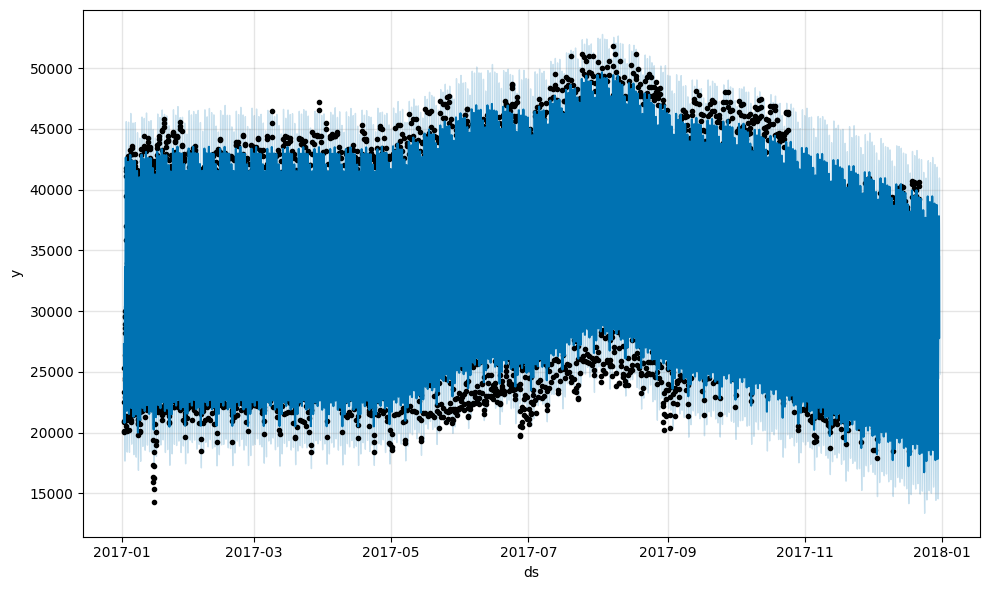

In [18]:
try:
    from prophet import Prophet
    df_prop=feat.reset_index()[['DateTime','y']].rename(columns={'DateTime':'ds','y':'y'})
    m=Prophet(daily_seasonality=True,weekly_seasonality=True,yearly_seasonality=False)
    m.fit(df_prop.iloc[:-200])
    future=m.make_future_dataframe(periods=200,freq='h')
    forecast=m.predict(future)
    fig=m.plot(forecast)
    plt.show()
except Exception as e:
    print('Prophet not available or failed to run:',e)
    print('Install prophet via: pip install prophet')

## Comparison and Next Steps

Compare RMSE/MAE from the models above and discuss which approach fits your use-case. Consider forecasting horizon, data frequency, and available exogenous variables (weather, calendar).

## Exercises & Quiz

1. Add weather features and re-evaluate model performance.
2. Implement time-series cross-validation (rolling origin) for robust evaluation.
3. Tune LSTM hyperparameters: layers, units, dropout, sequence length.

**Quiz:** Why is scaling important for LSTM? When might ARIMA outperform LSTM?